In [1]:
import h5py
import numpy as np
import pandas as pd
import json

In [2]:
import matplotlib
font = { 'size'   : 17}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append("DL1_framework/Training")
import train_tools as tt

Using TensorFlow backend.


In [4]:
file_Znunu = h5py.File("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/Znunu/Znunu_merged.h5", 'r')
df_Znunu = pd.DataFrame(file_Znunu['jets'][:])

file_Zmumu = h5py.File("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/Zmumu/Zmumu_merged.h5", 'r')
df_Zmumu = pd.DataFrame(file_Zmumu['jets'][:])

In [5]:
df_Znunu.replace([np.inf, -np.inf], np.nan, inplace=True)
df_Zmumu.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
df_bb_test = pd.concat([df_Zmumu, df_Znunu]).query("eventNumber%3==2")

In [7]:
file_tt_test = h5py.File("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/ttbar/MC16a_ttbar_EMTopo-no_pT-cuts_4M_odd.h5", 'r')
df_ttbar_valid = pd.DataFrame(file_tt_test['jets'][:int(2e6)])
# df_ttbar_test = pd.DataFrame(file_tt_test['jets'][int(1.5e6):])

In [6]:
train_vars = ["abs_eta_uncalib",
"pt_uncalib",
"JetFitter_mass",
"JetFitter_isDefaults",
"JetFitter_energyFraction",
"JetFitter_significance3d",
"JetFitter_nVTX",
"JetFitter_nSingleTracks",
"JetFitter_nTracksAtVtx",
"JetFitter_N2Tpair",
"JetFitter_deltaR",
"SV1_NGTinSvx",
"SV1_masssvx",
"SV1_isDefaults",
"SV1_N2Tpair",
"SV1_efracsvx",
"SV1_deltaR",
"SV1_Lxy",
"SV1_L3d",
"SV1_significance3d",
"IP2D_bu",
"IP2D_isDefaults",
"IP2D_bc",
"IP2D_cu",
"IP3D_bu",
"IP3D_isDefaults",
"IP3D_bc",
"IP3D_cu",
"secondaryVtx_nTrks",
"secondaryVtx_isDefaults",
"secondaryVtx_m",
"secondaryVtx_E",
"secondaryVtx_EFrac",
"secondaryVtx_L3d",
"secondaryVtx_Lxy",
"secondaryVtx_max_trk_flightDirRelEta",
"secondaryVtx_min_trk_flightDirRelEta",
"secondaryVtx_avg_trk_flightDirRelEta",
"max_trk_flightDirRelEta",
"min_trk_flightDirRelEta",
"avg_trk_flightDirRelEta",
"iprnn_pb",
"iprnn_pc",
"iprnn_pu",
"softMuon_dR",
"softMuon_qOverPratio",
"softMuon_momentumBalanceSignificance",
"softMuon_scatteringNeighbourSignificance",
"softMuon_pTrel",
"softMuon_ip3dD0",
"softMuon_ip3dZ0",
"softMuon_ip3dD0Significance",
"softMuon_ip3dZ0Significance",
"softMuon_isDefaults"
]
variablelist=train_vars

In [9]:
default_dict ="DL1_framework/Preprocessing/dicts/params_MC16D-ext_2018-PFlow_70-4M_mu.json"
with open(default_dict) as vardict:
                default_dict = json.load(vardict)
default_dict2 = tt.Gen_default_dict(default_dict)        

df_bb_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_bb_test.fillna(default_dict2, inplace=True)
df_ttbar_valid.replace([np.inf, -np.inf], np.nan, inplace=True)
df_ttbar_valid.fillna(default_dict2, inplace=True)

In [10]:
scale_dic = {}
for var in default_dict:
    scale_dic[var['name']] = var

In [20]:
for var in train_vars:
    df_bb_test[var] = (df_bb_test[var] - scale_dic[var]['shift'])/scale_dic[var]['scale']
    df_ttbar_valid[var] = (df_ttbar_valid[var] - scale_dic[var]['shift'])/scale_dic[var]['scale']

In [48]:
class_cut = "HadronConeExclExtendedTruthLabelID==0 | HadronConeExclExtendedTruthLabelID==4 | HadronConeExclExtendedTruthLabelID==5 | HadronConeExclExtendedTruthLabelID==55"
df_bb_test.query(class_cut, inplace=True)
df_ttbar_valid.query(class_cut, inplace=True)

In [49]:
df_comb_test = pd.concat([df_bb_test[train_vars], df_ttbar_valid[train_vars]])

In [50]:
labels_test = pd.concat([df_bb_test["HadronConeExclExtendedTruthLabelID"], 
                         df_ttbar_valid["HadronConeExclExtendedTruthLabelID"]])

In [51]:
labels_test.replace({0:0, 4:1, 5:2, 55:3}, inplace=True)

In [52]:
labels_test[labels_test==127]

Series([], Name: HadronConeExclExtendedTruthLabelID, dtype: int64)

In [53]:
from keras.utils import np_utils
Y_test = np_utils.to_categorical(labels_test.values, 4)
# X_test = df_comb_test.values()

In [54]:
df_comb_test.to_hdf("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/test_Xtrain.h5", "X_train")
np.save("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/test_Ytrain.h5", Y_test)

In [27]:
len(df_Znunu.query("eventNumber%3<2"))+len(df_Zmumu.query("eventNumber%3<2"))

1014351

In [6]:
len(df_Znunu.query("eventNumber%3==2"))+len(df_Zmumu.query("eventNumber%3==2"))

508020

In [7]:
df_comb_bb = pd.concat([df_Zmumu, df_Znunu])

In [9]:
# df_

In [10]:
bb_train = df_comb_bb.query("eventNumber%3<2")
bb_test = df_comb_bb.query("eventNumber%3==2")

In [11]:
file_ttbar = h5py.File("/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/ttbar/MC16a_ttbar_EMTopo-no_pT-cuts_6M.h5", 'r')
df_ttbar = pd.DataFrame(file_ttbar['jets'][:])

In [12]:
df_ttbar.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
print("bjets", len(df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")))
print("cjets", len(df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")))
print("ujets", len(df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")))

bjets 2276873
cjets 473558
ujets 2960004


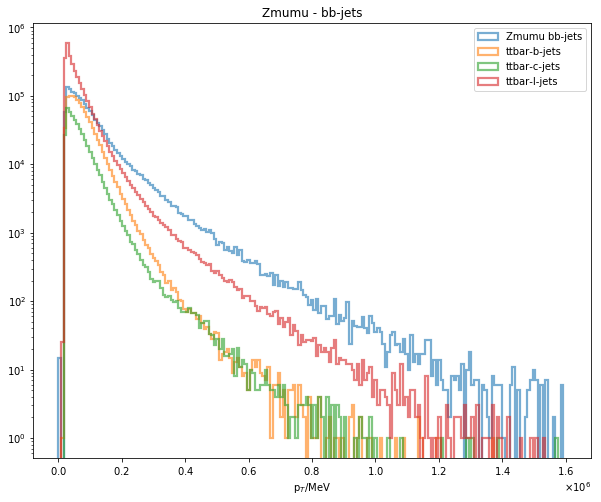

In [17]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)


var = "pt_uncalib"


# plt.hist([df_70['pt_uncalib'], df_140['pt_uncalib'], df_280['pt_uncalib'], df_500['pt_uncalib'], df_1000['pt_uncalib']], 
# #          bins='auto', histtype='step', density=1,
#           bins=np.linspace(0, 1.6e6, 200), histtype='step',
#          label=["0-70", "70-140", "140-280", "280-500", "500-1000", "1000-E"],
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)

# plt.hist(pd.concat([df_70['pt_uncalib'], df_140['pt_uncalib'], df_280['pt_uncalib'], df_500['pt_uncalib'], df_1000['pt_uncalib']]), 
#          bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
#          label=["Zmumu bb-jets"],
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.hist(df_comb_bb["pt_uncalib"], 
         bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
         label=["Zmumu bb-jets"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")['pt_uncalib'][:1000000], 
         bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
         label=["ttbar-b-jets"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")['pt_uncalib'], 
         bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
         label=["ttbar-c-jets"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)

plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")['pt_uncalib'], 
         bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
         label=["ttbar-l-jets"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)


# plt.hist(pd.concat([df_3['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["0-70"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_2['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["70-140"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["140-280"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_4['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["280-500"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_5['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["500-1000"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_6['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["1000-E"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)


plt.xlabel('p$_T$/MeV')
plt.yscale('log')
# plt.xscale('log')
plt.title('Zmumu - bb-jets')
plt.legend()
# plt.savefig("bbjets-Zmumu.pdf", transparent=True)

In [65]:
# .cut('pt_uncalib')

# d1 = df.assign(
#     pt_cut=df_ttbar.qcut(df.pt_uncalib, 2, labels=[1, 2]),
#     eta_cut=df_ttbar.qcut(df.eta_uncalib, 2, labels=list('ab'))
# )

pt_bins = np.linspace(2e4, 1.6e6, 395)  # adaptation to cut out very low pt bins
eta_bins = np.linspace(0, 2.5, 50)

pt_cut = df_ttbar.assign(
    pt_cut = pd.cut(df_ttbar.pt_uncalib, pt_bins, labels=range(len(pt_bins)-1)),
    eta_cut = pd.cut(df_ttbar.abs_eta_uncalib, eta_bins, labels=range(len(eta_bins)-1))        
)

In [66]:
pt_cut.query("pt_cut==pt_cut & eta_cut==eta_cut", inplace=True)

In [67]:
pt_cut["d2_cut"] = list(zip(pt_cut.pt_cut, pt_cut.eta_cut))

In [74]:
# labels = pt_cut.d2_cut.astype('category').codes
# type(labels)
raw_cat_pt = pd.Categorical(pt_cut["pt_cut"] , ordered=True)
raw_cat_eta = pd.Categorical(pt_cut["eta_cut"] , ordered=True)
raw_cat = pd.Categorical(pt_cut["d2_cut"] , ordered=True)

In [75]:
raw_cat_eta.codes

array([ 6, 11, 39, ..., 35, 16,  0], dtype=int8)

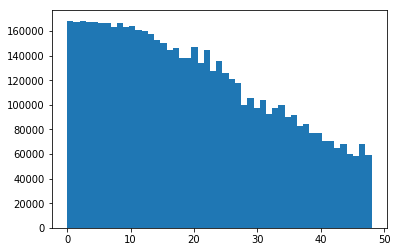

In [82]:
plt.hist(raw_cat_eta.codes, 49)
None

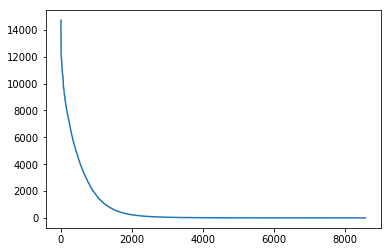

In [36]:
plt.plot(np.arange(len(counts)), counts)

In [34]:
counts = pd.value_counts(pt_cut["2d_cut"])

In [69]:
pd.pivot_table(d2[['pt_cut', 'eta_cut', 'pt_uncalib']],  index=['pt_cut', 'eta_cut'])

pt_uncalib
pt_cut eta_cut               
0      0         22384.828125
       1         22100.978516
       2         22276.214844
       3         21887.855469
       4         22491.789062
       5         23093.222656
       6         22516.187500
       7         21320.732422
       8         21653.312500
       9         22664.535156
       10        21959.156250
       11        22843.484375
       12        22663.251953
       13        22299.734375
       14        22889.939453
       15        23442.941406
       16        22652.474609
       17        22654.470703
       18        21580.800781
       19        22187.642578
       20        22371.658203
       21        22337.306641
       22        23395.736328
       23        22764.769531
       24        22971.005859
       26        23288.371094
       27        22688.628906
       29        22858.224609
       30        23967.964844
       32        22907.271484
...                       ...
56     40       247354.718750
58     15       255114.312500
       38       256423.234375
59     1        258371.890625
       13       259782.421875
       34       258130.343750
61     1        267483.906250
62     0        271385.343750
63     30       276077.125000
64     13       278685.937500
66     8        287599.343750
       15       287257.937500
       43       286961.093750
68     11       296091.156250
72     18       310335.281250
75     27       322260.125000
77     5        332313.593750
       18       330944.593750
80     33       343085.500000
       44       344542.343750
81     20       347700.718750
83     18       356836.718750
86     5        365926.875000
90     3        384570.562500
       5        381938.312500
102    4        431212.125000
103    40       435427.531250
121    37       506378.437500
131    11       546870.750000
134    2        557780.187500

[1215 rows x 1 columns]

In [64]:
d2 = pt_cut[:3000].assign(cartesian=pd.Categorical(pt_cut[:3000].filter(regex='_cut').apply(tuple, 1)))
print(d2["cartesian"])

0        (6, 10.0)
1        (11, 2.0)
2        (39, 0.0)
3        (12, 1.0)
4        (0, 30.0)
5       (14, 10.0)
6        (13, 7.0)
7       (25, 22.0)
8        (29, 1.0)
9        (2, 10.0)
10       (0, 62.0)
11       (21, 1.0)
12      (20, 14.0)
13       (18, 3.0)
14      (38, 21.0)
15       (12, 4.0)
16       (37, 2.0)
17      (42, 17.0)
18      (20, 12.0)
19        (7, 1.0)
20        (6, 9.0)
21        (3, 0.0)
22       (32, 1.0)
23        (3, 3.0)
24       (3, 17.0)
25      (31, 12.0)
26       (4, 32.0)
27       (12, 1.0)
28       (19, 3.0)
29       (1, 36.0)
           ...    
2970      (0, 0.0)
2971     (26, 1.0)
2972     (38, 9.0)
2973    (42, 10.0)
2974    (48, 27.0)
2975     (7, 38.0)
2976     (7, 10.0)
2977    (32, 14.0)
2978      (8, 3.0)
2979    (29, 13.0)
2980    (14, 20.0)
2981      (8, 6.0)
2982    (45, 11.0)
2983    (33, 19.0)
2984     (21, 9.0)
2985      (9, 7.0)
2986     (35, 6.0)
2987    (34, 19.0)
2988     (44, 3.0)
2989     (22, 6.0)
2990    (11, 15.0)
2991    (19,

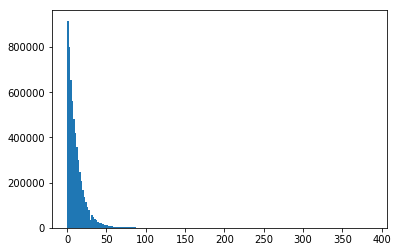

In [36]:
plt.hist(np.array(pt_cut.dropna()), 200)
None

In [44]:
pd_cut = pd.DataFrame(pt_cut)
pd_cut['pt'] = df_ttbar["pt_uncalib"]

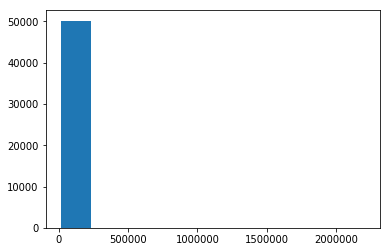

In [53]:
plt.hist(pd_cut.query("pt_uncalib!=pt_uncalib")['pt'])
None

In [37]:
print(len(pt_cut.dropna()))
print(len(pt_cut))

5949803
6000000


In [9]:
from hep_ml.reweight import BinsReweighter

In [41]:
pt_bins = np.linspace(0, 6e6, 400)
eta_bins = np.linspace(0, 2.5, 26)

histvals_b = np.histogram2d(w_target['abs_eta_uncalib'], w_target['pt_uncalib'], [eta_bins, pt_bins])
histvals_bb = np.histogram2d(df_comb_bb['abs_eta_uncalib'], df_comb_bb['pt_uncalib'], [eta_bins, pt_bins])

histvals_b = histvals_b[0]
histvals_bb = histvals_bb[0]

histvals_b[histvals_b == 0] = 1
histvals_bb[histvals_bb == 0] = 1

bbweight_hist = np.divide(histvals_b, histvals_bb)

bb_locations_pt = np.digitize(df_comb_bb['pt_uncalib'].values,pt_bins)
bb_locations_eta = np.digitize(df_comb_bb['abs_eta_uncalib'].values,eta_bins)

bb_locations_pt[bb_locations_pt >= len(pt_bins)-1] = len(pt_bins)-2
bb_locations_eta[bb_locations_eta >= len(eta_bins)-1] = len(eta_bins)-2

b_weights = np.ones(len(w_target))
bb_weights = np.array([bbweight_hist[x] for x in zip(bb_locations_eta,bb_locations_pt)])

1000000

In [43]:
w_target = df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")[['pt_uncalib', 'abs_eta_uncalib']][:1000000]

In [11]:
reweighter_c = BinsReweighter(n_bins=400, n_neighs=2)
reweighter_c.fit(original=df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")[['pt_uncalib', 'abs_eta_uncalib']], target=w_target)
c_weights = reweighter_c.predict_weights(df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")[['pt_uncalib', 'abs_eta_uncalib']])

In [12]:
reweighter_u = BinsReweighter(n_bins=400, n_neighs=2)
reweighter_u.fit(original=df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")[['pt_uncalib', 'abs_eta_uncalib']], target=w_target)
u_weights = reweighter_u.predict_weights(df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")[['pt_uncalib', 'abs_eta_uncalib']])

In [74]:
reweighter_bb = BinsReweighter(n_bins=400, n_neighs=4)
reweighter_bb.fit(original=df_comb_bb[['pt_uncalib', 'abs_eta_uncalib']], target=w_target)
bb_weights = reweighter_bb.predict_weights(df_comb_bb[['pt_uncalib', 'abs_eta_uncalib']])

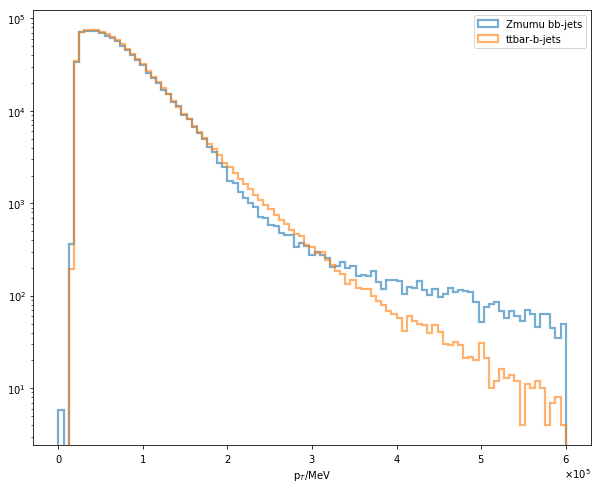

In [75]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)


var = "pt_uncalib"

plt.hist(df_comb_bb["pt_uncalib"], 
         bins=np.linspace(0, 0.6e6, 100), histtype='step',# density=1,
         label=["Zmumu bb-jets"], weights=bb_weights,
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")['pt_uncalib'][:1000000], 
         bins=np.linspace(0, 0.6e6, 100), histtype='step',# density=1,
         label=["ttbar-b-jets"], 
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")['pt_uncalib'], 
#          bins=np.linspace(0, 0.6e6, 200), histtype='step',# density=1,
#          label=["ttbar-c-jets"], weights=c_weights,
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)

# plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")['pt_uncalib'], 
#          bins=np.linspace(0, 0.6e6, 200), histtype='step',# density=1,
#          label=["ttbar-l-jets"], weights=u_weights,
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.xlabel('p$_T$/MeV')
plt.yscale('log')
# plt.xscale('log')
# plt.title('Zmumu - bb-jets')
plt.legend()
None

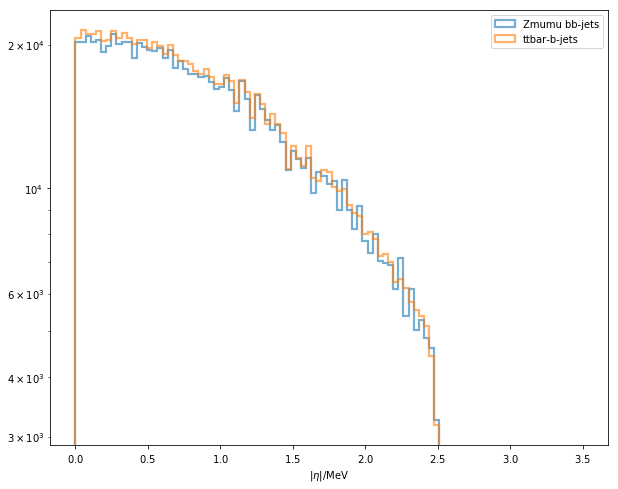

In [78]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)


var = "pt_uncalib"

plt.hist(df_comb_bb["abs_eta_uncalib"], 
         bins=np.linspace(0, 3.5, 100), histtype='step',# density=1,
         label=["Zmumu bb-jets"], weights=bb_weights,
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")['abs_eta_uncalib'][:1000000], 
         bins=np.linspace(0, 3.5, 100), histtype='step',# density=1,
         label=["ttbar-b-jets"], 
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")['pt_uncalib'], 
#          bins=np.linspace(0, 0.6e6, 200), histtype='step',# density=1,
#          label=["ttbar-c-jets"], weights=c_weights,
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)

# plt.hist(df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")['pt_uncalib'], 
#          bins=np.linspace(0, 0.6e6, 200), histtype='step',# density=1,
#          label=["ttbar-l-jets"], weights=u_weights,
#          stacked=False, fill=False, linewidth=2.2, alpha=0.6)
plt.xlabel('$|\eta|$/MeV')
plt.yscale('log')
# plt.xscale('log')
# plt.title('Zmumu - bb-jets')
plt.legend()
None

In [60]:
df_comb_bb["weight"] = bb_weights
df_bjets = df_ttbar.query("HadronConeExclExtendedTruthLabelID==5")[:1000000]
df_bjets["weight"] = np.ones(len(df_bjets))
# df_cjets = df_ttbar.query("HadronConeExclExtendedTruthLabelID==4")
# df_cjets["weight"] = c_weights
# df_ujets = df_ttbar.query("HadronConeExclExtendedTruthLabelID==0")
# df_ujets["weight"] = u_weights

In [61]:
outfile = "/home/manuel/Desktop/work_btag/gluon_fusion_ntuples/new-taggers/trainfile.h5"
df_comb_bb.to_hdf(outfile, "bbjets")
df_bjets.to_hdf(outfile, "bjets")
# df_cjets.to_hdf(outfile, "cjets")
# df_ujets.to_hdf(outfile, "ujets")

In [38]:
print(len(df_comb_bb))
print(len(df_bjets))
print(len(df_cjets))
print(len(df_ujets))

853525
2276873
473558
2960004


In [17]:
variablelist =[
"abs_eta_uncalib",
"pt_uncalib",
"JetFitter_mass",
"JetFitter_energyFraction",
"JetFitter_significance3d",
"JetFitter_nVTX",
"JetFitter_nSingleTracks",
"JetFitter_nTracksAtVtx",
"JetFitter_N2Tpair",
"JetFitter_deltaR",
"SV1_NGTinSvx",
"SV1_masssvx",
"SV1_N2Tpair",
"SV1_efracsvx",
"SV1_deltaR",
"SV1_Lxy",
"SV1_L3d",
"SV1_significance3d",
"IP2D_bu",
"IP2D_bc",
"IP2D_cu",
"IP3D_bu",
"IP3D_bc",
"IP3D_cu",
"secondaryVtx_nTrks",
"secondaryVtx_isDefaults",
"secondaryVtx_m",
"secondaryVtx_E",
"secondaryVtx_EFrac",
"secondaryVtx_L3d",
"secondaryVtx_Lxy",
"secondaryVtx_max_trk_flightDirRelEta",
"secondaryVtx_min_trk_flightDirRelEta",
"secondaryVtx_avg_trk_flightDirRelEta",
"max_trk_flightDirRelEta",
"min_trk_flightDirRelEta",
"avg_trk_flightDirRelEta",
"iprnn_pb",
"iprnn_pc",
"iprnn_pu",
"softMuon_dR",
"softMuon_qOverPratio",
"softMuon_momentumBalanceSignificance",
"softMuon_scatteringNeighbourSignificance",
"softMuon_pTrel",
"softMuon_ip3dD0",
"softMuon_ip3dZ0",
"softMuon_ip3dD0Significance",
"softMuon_ip3dZ0Significance"
]

In [18]:
print(df_comb_bb.columns.values)

['MV2c10_discriminant' 'MV2r_discriminant' 'MV2rmu_discriminant' 'DL1_pu'
 'DL1_pc' 'DL1_pb' 'DL1r_pu' 'DL1r_pc' 'DL1r_pb' 'DL1rmu_pu' 'DL1rmu_pc'
 'DL1rmu_pb' 'IP2D_pu' 'IP2D_pc' 'IP2D_pb' 'IP3D_pu' 'IP3D_pc' 'IP3D_pb'
 'SV1_pu' 'SV1_pc' 'SV1_pb' 'rnnip_pu' 'rnnip_pc' 'rnnip_pb' 'rnnip_ptau'
 'pt_uncalib' 'eta_uncalib' 'abs_eta_uncalib' 'IP2D_cu' 'IP2D_bu'
 'IP2D_bc' 'IP3D_cu' 'IP3D_bu' 'IP3D_bc' 'secondaryVtx_m' 'secondaryVtx_E'
 'secondaryVtx_EFrac' 'secondaryVtx_min_trk_flightDirRelEta'
 'secondaryVtx_max_trk_flightDirRelEta'
 'secondaryVtx_avg_trk_flightDirRelEta' 'min_trk_flightDirRelEta'
 'max_trk_flightDirRelEta' 'avg_trk_flightDirRelEta' 'SMT_discriminant'
 'JetFitter_energyFraction' 'JetFitter_mass' 'JetFitter_significance3d'
 'JetFitter_deltaphi' 'JetFitter_deltaeta' 'JetFitter_massUncorr'
 'JetFitter_dRFlightDir' 'SV1_masssvx' 'SV1_efracsvx' 'SV1_significance3d'
 'SV1_dstToMatLay' 'SV1_deltaR' 'SV1_Lxy' 'SV1_L3d' 'softMuon_pt'
 'softMuon_dR' 'softMuon_eta' 'softMuon_phi' 's

In [46]:
df_bjets.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cjets.replace([np.inf, -np.inf], np.nan, inplace=True)
df_ujets.replace([np.inf, -np.inf], np.nan, inplace=True)

/home/manuel/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


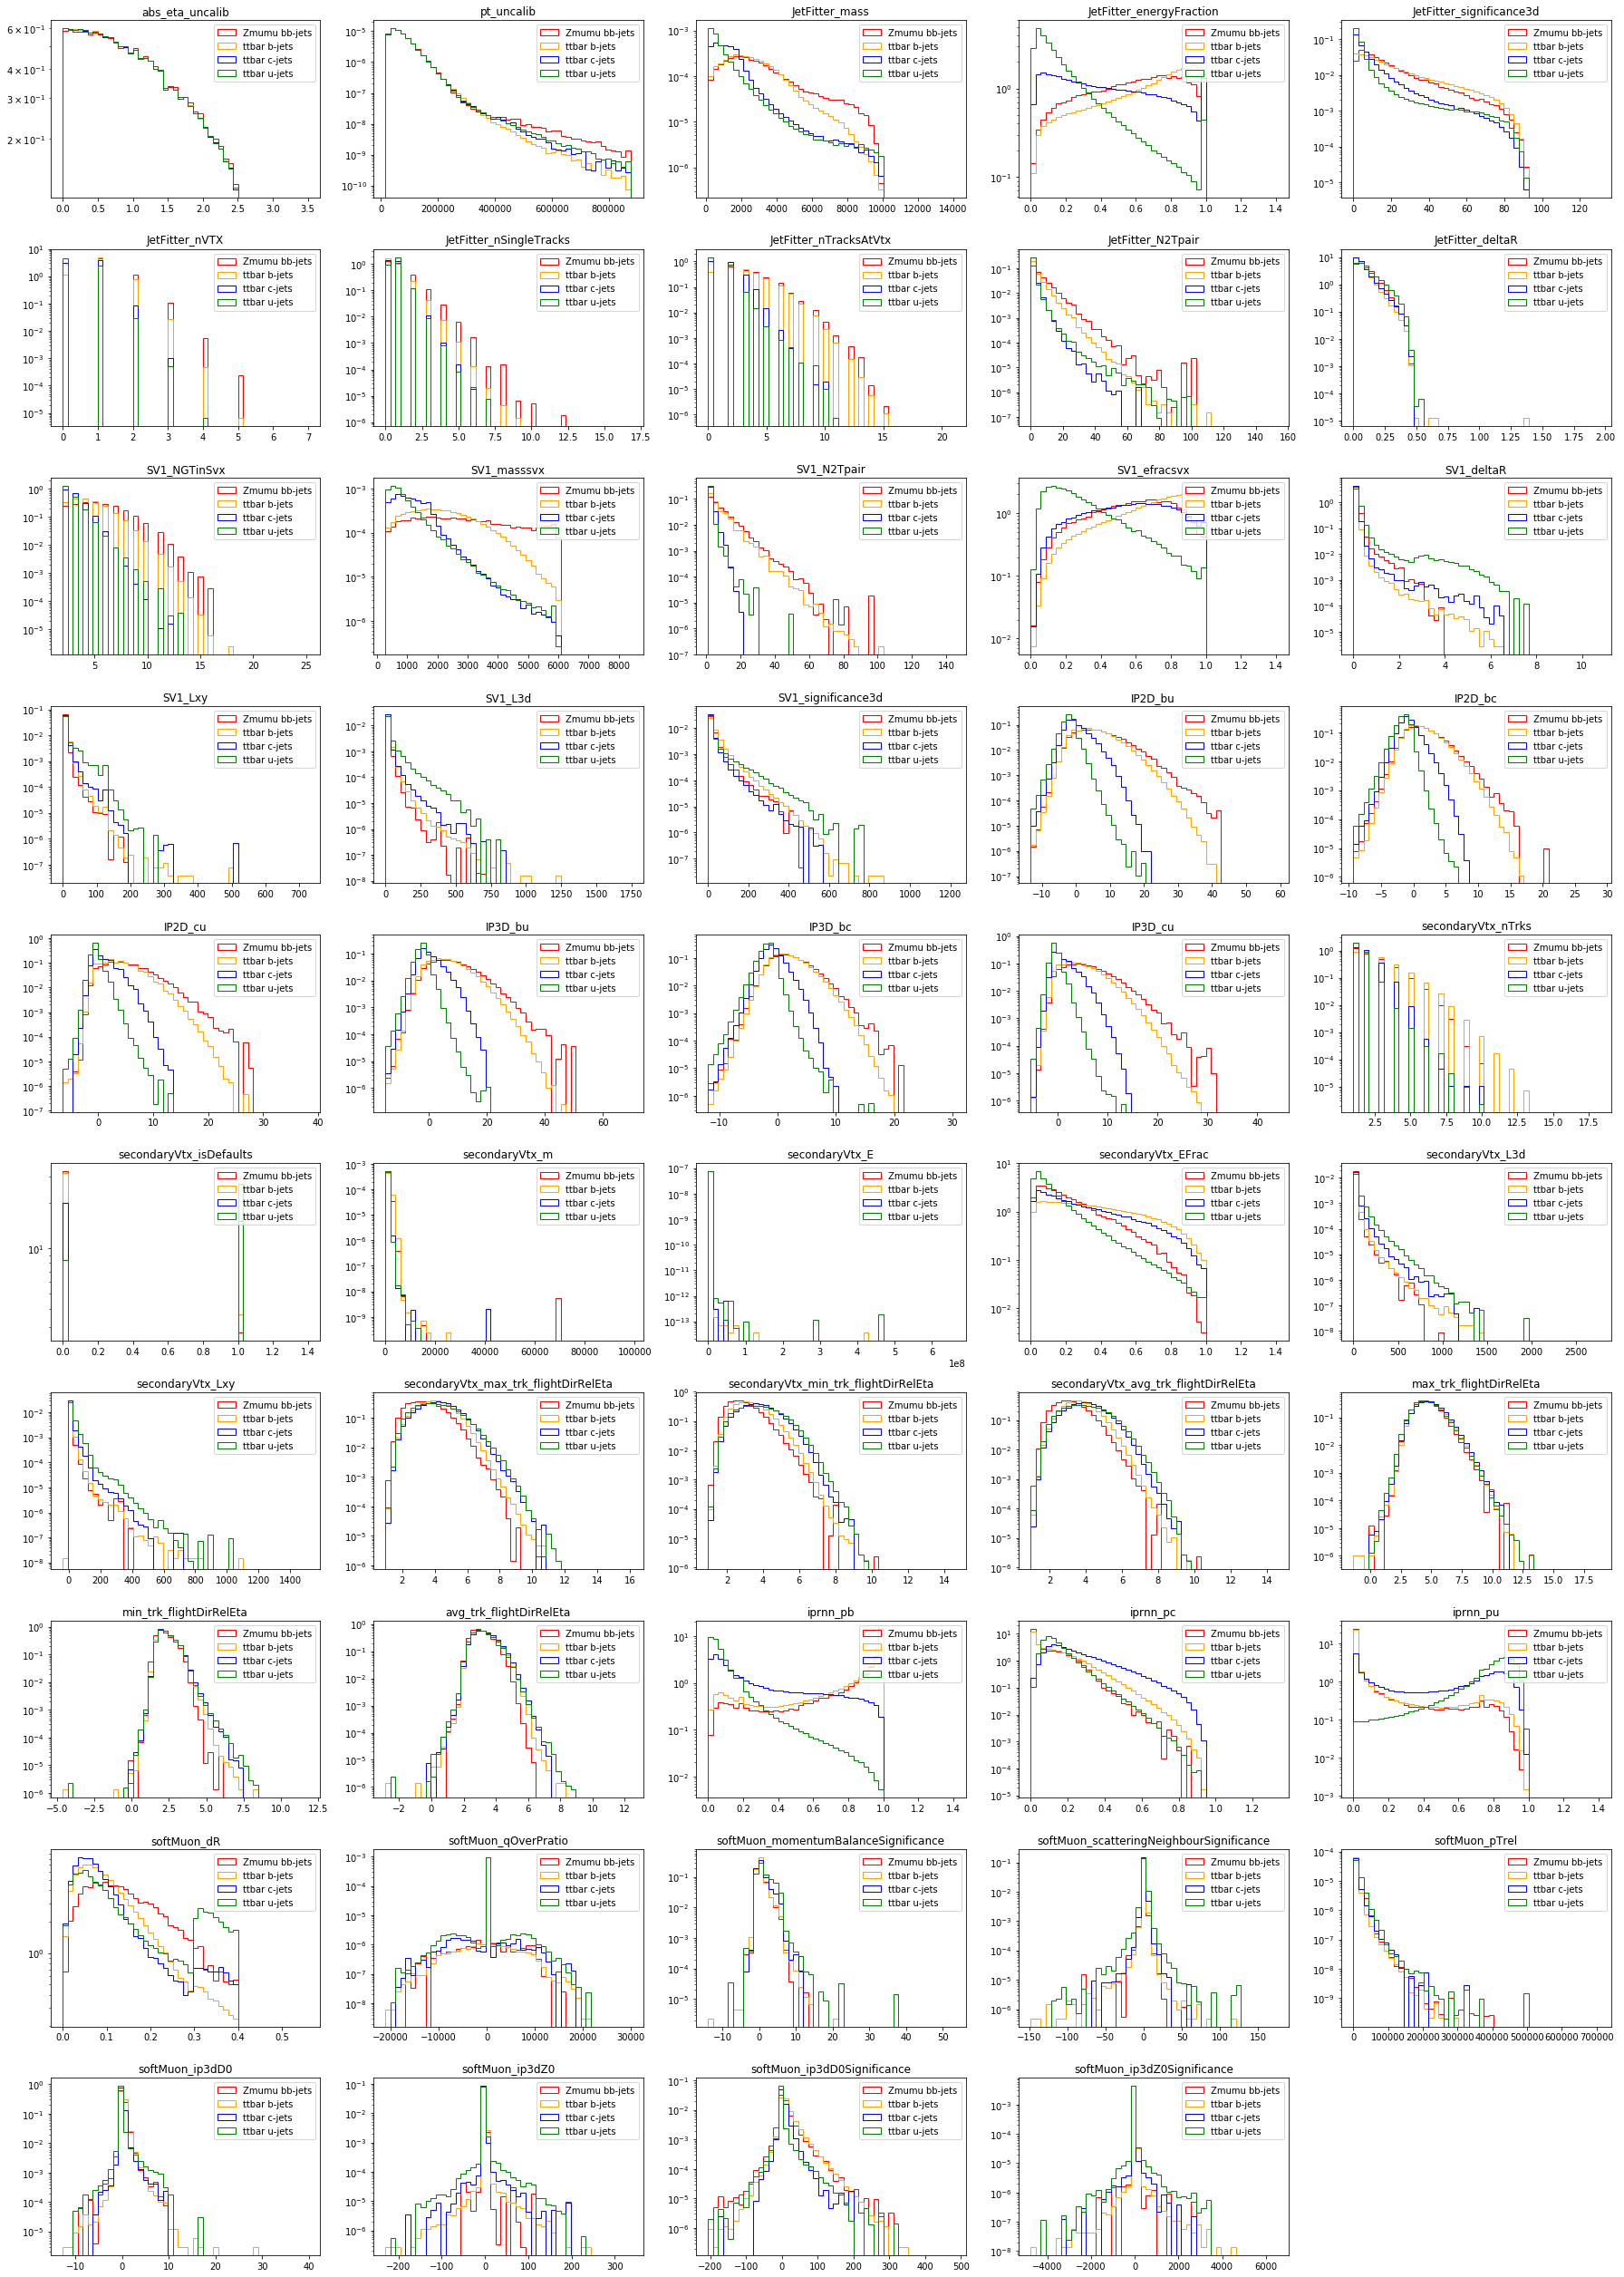

In [36]:
fig, ax = plt.subplots(10, 5, figsize=(25, 35))
nbins = 50
# nbins = 20

varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(variablelist):
#             X = df[[variablelist[varcounter], 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID']]
#             X = df.query('min_trk_flightDirRelEta>5.25')[[variablelist[varcounter], 'HadronConeExclTruthLabelID']]
#             X.dropna(inplace=True)
            var = variablelist[varcounter]
            bb = df_comb_bb[[var, "weight"]].dropna()
            b = df_bjets[[var, "weight"]].dropna()
            c = df_cjets[[var, "weight"]].dropna()
            u = df_ujets[[var, "weight"]].dropna()
            


            minval = np.amin(b[var])
            if 'pt' in var:
                maxval = np.percentile(u[var],99.99)
            else:
                maxval = max([np.amax(u[var]), np.amax(c[var]), np.amax(b[var]), np.amax(bb[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)

            axobj.hist(bb[var],binning,histtype=u'step', color='r',label='Zmumu bb-jets',density=1, weights=bb["weight"])
            axobj.hist(b[var],binning,histtype=u'step', color='orange',label='ttbar b-jets',density=1, weights=b["weight"])
            axobj.hist(c[var],binning,histtype=u'step', color='b',label='ttbar c-jets',density=1, weights=c["weight"])
            axobj.hist(u[var],binning,histtype=u'step', color='g',label='ttbar u-jets',density=1, weights=u["weight"])

            
            axobj.legend()
            axobj.set_yscale('log',nonposy='clip')
            axobj.set_title(variablelist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
#plt.savefig('mc16d_train_ttbar.pdf')
plt.savefig("Zmumu-btagVars-new.pdf", transparent=True)
plt.show()

In [31]:
len(df_comb_bb.query("SV1_masssvx>6000"))

0

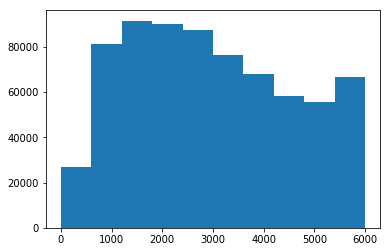

In [35]:
plt.hist(df_comb_bb["SV1_masssvx"].dropna())
None

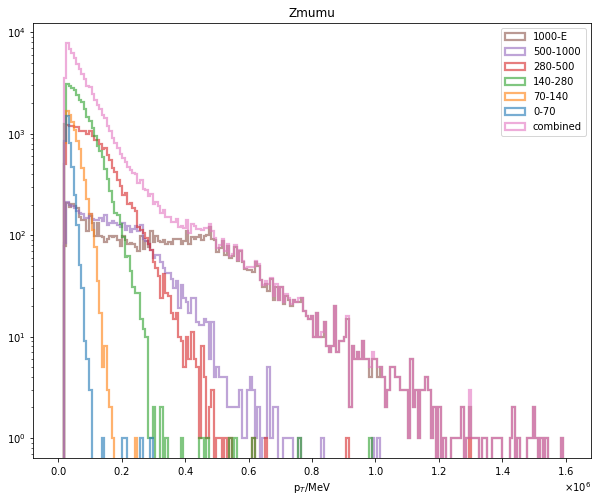

In [50]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)


var = "pt_uncalib"


plt.hist([df_3.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_2.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_4.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_5.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_6.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib']], 
#          bins='auto', histtype='step', density=1,
          bins=np.linspace(0, 1.6e6, 200), histtype='step',
         label=["0-70", "70-140", "140-280", "280-500", "500-1000", "1000-E"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)

plt.hist(pd.concat([df_3.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_2.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_4.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_5.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib'],df_6.query('HadronConeExclExtendedTruthLabelID==55')['pt_uncalib']]), 
         bins=np.linspace(0, 1.6e6, 200), histtype='step',# density=1,
         label=["combined"],
         stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_3['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["0-70"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_2['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["70-140"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["140-280"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_4['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["280-500"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_5['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["500-1000"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)
# plt.hist(pd.concat([df_6['pt_uncalib']]), bins='auto', histtype='step', #normed=1,
#                  label=["1000-E"],stacked=False, fill=False, linewidth=2.2, alpha=0.6)


plt.xlabel('p$_T$/MeV')
plt.yscale('log')
# plt.xscale('log')
plt.title('Zmumu')
plt.legend()
plt.savefig("bbjets-Zmumu.pdf", transparent=True)

In [55]:
from matplotlib import gridspec
def plotRatio(hist_arrs, kargs_arrs, xrange=None, normed=True, nBins=100,
              logY=True, rrange=None, xlabel='', ylabel='', title='',
              tag='', figDir='../figures',subDir=''):
    '''

    Given a list of arrays, overlay the histograms and compare the

    Inputs:
    - hist_arrs:  List of numpy arrays, where the first element of the list is the
                  histogram that we're comparing the others to
    - kargs_arrs: A list of the key word arguments that will be passed to each
                  histogram to be plotted
    - xrange: The range for the xaxis of the histograms
    - normed: Whether the histograms should be normalized
    - nBins: number of bins
    - logY: whether the yaxis for the overlaid histograms should be logarithmic
    - rrange: The range on the y-axis for the ratio panel

    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    - title:  Title for the figure

    - tag: If not an empty string, save the file in the ../figures
    - subDir: If this (and tag) is not an empty string, save the file in this subdirectory

    '''
    assert len(hist_arrs) == len(kargs_arrs) # input arrays must be the same length
    
    # Define the figure with two subplots of unequal sizes
    fig = plt.figure()
    gs = gridspec.GridSpec(7,1)
    ax1 = fig.add_subplot(gs[:6,0])
    ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)
    ax2 = fig.add_subplot(gs[6:,0])
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 3),
                             useMathText=True)

    for i, (arr, kargs) in enumerate(zip(hist_arrs, kargs_arrs)):

        # Plot the histgram
        n, bins, _ = ax1.hist(arr, range=xrange, bins=nBins, density=normed, log=logY, **kargs)

        if i == 0:
           nFirst = n
        if i > 0:
           ax2.plot((bins[:-1]+bins[:1])/2, n/nFirst, color=kargs['color'] )

    # Add a line indicating ratio=1
#     ax2.plot(xrange,[1,1],'k--')
    if rrange is not None:
        ax2.set_ylim(rrange)

    # Add axes, titles and the legend
    ax1.set_ylabel('Arbitrary units')
    ax2.set_xlabel(xlabel,fontsize=14)
    ax2.set_ylabel('Ratio')
    ax1.set_title(title)
    ax1.legend()

    if len(tag) > 0:
        plt.savefig('{}/{}/cf_{}.pdf'.format(figDir,subDir,tag))

    plt.show()


/home/manuel/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/manuel/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


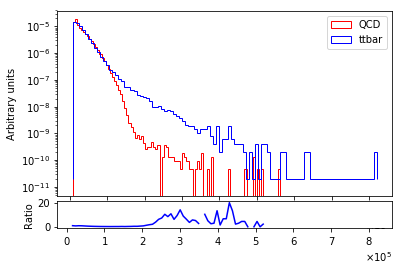

In [68]:
plotRatio([df['pt_uncalib'], df_tt['pt_uncalib']], 
          [{"color": 'r', "histtype":'step', "stacked":False, "fill":False, 'label': 'QCD'}, 
           {"color": 'b', "histtype":'step', "stacked":False, "fill":False, 'label': 'ttbar'}])